# Feature Extractor

In [1]:
import tensorflow as tf
tf.random.set_seed(221)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import cv2
import os

extract_feature = True

Resnet18

In [2]:
if extract_feature:
    import timm

    model = timm.create_model(
        'resnet18.a1_in1k',
        pretrained=True,
        num_classes=0,  # remove classifier nn.Linear
    )
    model = model.eval()

    # get model specific transforms (normalization, resize)
    data_config = timm.data.resolve_model_data_config(model)
    transforms = timm.data.create_transform(**data_config, is_training=False)


In [5]:
def load_images_from_folders(base_path):
    images = []
    labels = []

    # Traverse the base directory
    for label in os.listdir(base_path):
        label_path = os.path.join(base_path, label)
        
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                if not image_name.endswith('.png'):
                    image_path = os.path.join(label_path, image_name)
                
                    try:
                        # Open and load the image
                        with Image.open(image_path) as img:
                            images.append(img.copy())
                            labels.append(label)
                    except Exception as e:
                        print(f"Error loading image {image_path}: {e}")
    
    return images, labels


In [7]:
# train
base_path = 'E:/Work/DS/Datasets/Raw/Industrial/Surface Defect/'
images, labels = load_images_from_folders(base_path)

# Print the number of images loaded and their corresponding labels
print(f"Number of images loaded: {len(images)}")
print(f"Number of labels images loaded: {len(labels)}")

Number of images loaded: 1344
Number of labels images loaded: 1344


Test print image

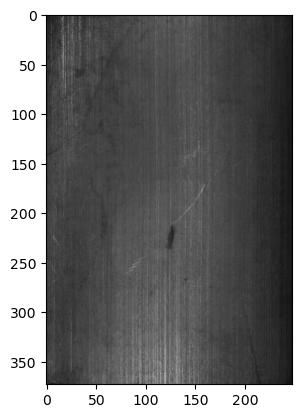

In [20]:
if extract_feature:
    img = np.array(images[0])

    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    plt.imshow(img)
    plt.show()

Process images from the cifar10 for the unwrapper

In [26]:
def process_minibatch(minibatch):
    batch_data = []
    for image in minibatch:
        # Convert to PIL image format
        img = Image.fromarray(cv2.cvtColor(np.array(image), cv2.COLOR_GRAY2RGB))
        # transform to model format and stack
        img = transforms(img)
        batch_data.append(img)
    batch_data = torch.stack(batch_data)
    # run through the resnet
    processed_data = model(batch_data)
    return processed_data

In [27]:
def feature_extraction(images,labels, is_train = False):

    output_df = pd.DataFrame(columns=['Class'])

    MINIBATCH_SIZE = 224

    # Convert the list of images to a batch tensor
    if is_train:
        NUMBER_MINIBATCH = 1344/MINIBATCH_SIZE
    else:
        NUMBER_MINIBATCH = 1344/MINIBATCH_SIZE
    for i in range(0,int(NUMBER_MINIBATCH)):
        print('processing minibatch %d out of %d' %(i+1 , int(NUMBER_MINIBATCH)))
        minibatch = images[i*MINIBATCH_SIZE:(i+1)*MINIBATCH_SIZE]

        # get features and put into df format
        minibatch_output = process_minibatch(minibatch)
        minibatch_output_df = pd.DataFrame(minibatch_output.detach().numpy(), columns=[f'features_{i}' for i in range(512)])
        minibatch_output_df['Class'] = labels[i*MINIBATCH_SIZE:(i+1)*MINIBATCH_SIZE]

        output_df = pd.concat([output_df, minibatch_output_df], ignore_index=True)
    return output_df

In [28]:
import pandas as pd
if extract_feature:
    train = feature_extraction(images,labels, is_train = True)
    train.to_csv('extracted_features.csv', index = False)
else:
    train = pd.read_csv('extracted_features.csv')


processing minibatch 1 out of 6
processing minibatch 2 out of 6
processing minibatch 3 out of 6
processing minibatch 4 out of 6
processing minibatch 5 out of 6
processing minibatch 6 out of 6


In [29]:
print(train.head())
print(train.shape)

         Class  features_0  features_1  features_2  features_3  features_4  \
0  MT_Blowhole         0.0         0.0    1.080014    0.203641    0.169155   
1  MT_Blowhole         0.0         0.0    1.132235    0.115664    0.146837   
2  MT_Blowhole         0.0         0.0    1.091269    0.000000    0.000000   
3  MT_Blowhole         0.0         0.0    0.888158    0.000000    0.000000   
4  MT_Blowhole         0.0         0.0    1.143326    0.000000    0.000000   

   features_5  features_6  features_7  features_8  ...  features_502  \
0    0.052944    0.084522    0.007093    0.025848  ...           0.0   
1    0.049710    0.068696    0.000000    0.016560  ...           0.0   
2    0.034446    0.000000    0.004126    0.006237  ...           0.0   
3    0.012287    0.004254    0.000000    0.003200  ...           0.0   
4    0.000000    0.000000    0.000000    0.000000  ...           0.0   

   features_503  features_504  features_505  features_506  features_507  \
0      0.309690        

Do the same for test set